In [1]:
from train.train_mlp import train_step
from models.MLP import GaussianMLP
import optax
from flax.training import train_state
from tqdm import trange
from diffusion.equations import *
from config import Config
from jax import random
from utils.viz import scatter_plot

In [2]:
key = random.PRNGKey(Config.SEED)
key, init_key = random.split(key)

In [3]:
from datasets.Gaussians import GaussianDataset
gaussian_dataset = GaussianDataset()
sample_data = gaussian_dataset.sample_data()
datapoints, dimension = sample_data.shape

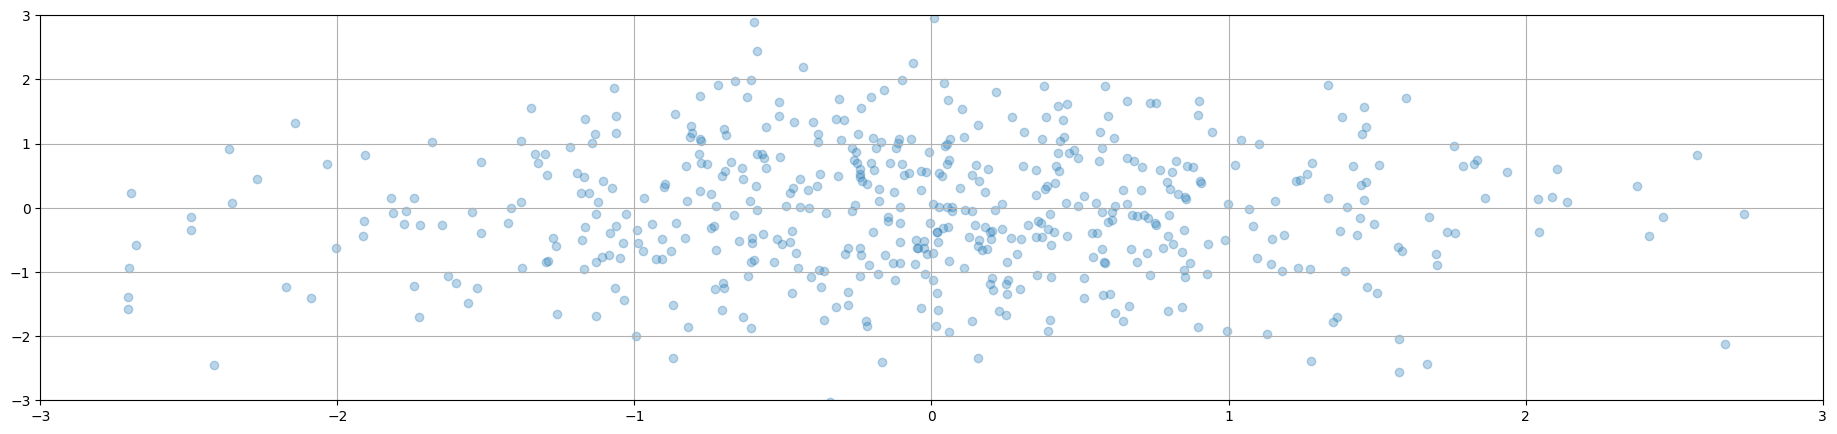

In [4]:
timesteps = np.linspace(0.0, 1.0, 6)
x_ts = forward_steps(gaussian_dataset.key, sample_data, timesteps)
x_t = forward_step(gaussian_dataset.key, sample_data, timesteps)
scatter_plot(x_t)

In [5]:
model = GaussianMLP(num_hid=512, num_out=2)
optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(init_key, np.ones((512, 1)), x_t),
    tx=optimizer
)

In [7]:
key, loc_key = random.split(key)
state, loss = train_step(state, sample_data, loc_key)

ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'jaxlib.xla_extension.ArrayImpl'>, [[-1.5355377  -1.4995826 ]
 [-2.0031862  -1.6512866 ]
 [ 1.0203129   2.2971895 ]
 ...
 [ 1.5238476   0.85570675]
 [-1.7370595  -1.1874804 ]
 [-1.489833   -1.6505777 ]]. The error was:
TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'


In [ ]:
num_iterations = 20_000

loss_plot = np.zeros(num_iterations)
key, loop_key = random.split(key)
for iter in trange(num_iterations):
  state, loss = train_step(state, datapoints, random.fold_in(loop_key, iter))
  loss_plot[iter] = loss

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(loss_plot)
plt.grid()

Interpretation (one line of math):

$$
x_{i+1}=x_i+\underbrace{-\mathbf{v}\left(t_i, x_i\right) d t}_{\text {drift }}+\underbrace{\sqrt{2 \xi \beta\left(t_i\right) d t} \varepsilon_i}_{\text {diffusion }}, \quad \varepsilon_i \sim \mathcal{N}(0, I) .
$$

- Drift term -dt*vector_field(...)
vector_field is your learned/constructed reverse-time velocity (often proportional to a score $\nabla_x \log q_t(x)$ times a schedule). The minus sign matches the standard reverse-SDE drift of the form

$$
f(x, t)-g(t)^2 \nabla_x \log q_t(x)
$$

(if you've absorbed the factors into vector_field).
- Noise term $\sqrt(2 \xi \beta(t) dt)\epsilon$

This is the Brownian increment with state-dependent scale $g(t)=\sqrt{2 \xi \beta(t)}$. beta(t) is your noise schedule; xi is a mobility/preconditioning scalar.

Shapes: beta(t) returns (bs,1) and broadcasts across the 2 features to multiply the (bs,2) Gaussian noise.
- Time update $\mathrm{t}+=-\mathrm{dt}$

All particles share the same scalar time, stored as ( $b s, 1$ ) for broadcasting; you march from $t=1$ to $t=0$ in 100 steps.

In [ ]:
`